In [1]:
import os, wandb

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jkrperson. Use `wandb login --relogin` to force relogin


True

In [1]:
from data import FakeNewsDataModule

In [2]:
from torch.utils.data import Dataset
import torch
import pandas as pd
# from textattack.augmentation import EasyDataAugmenter

class FakeNewsDataset(Dataset):
    def __init__(self, path_to_dataset, tokenizer):
        train_df = pd.read_csv(path_to_dataset, sep="\t")

        self.texts = train_df["claim"].to_list()
        self.labels = train_df["label"].to_list()
        self.tokenizer = tokenizer

        self.id2label = {0:'true', 
                         1:'false', 
                         2:'partly true/misleading', 
                         3:'mostly false' , 
                         4:'mostly true', 
                         5:'complicated/hard to categorise', 
                         6:'other'}
        
        self.label2id = {'true':0, 'false':1 , 'partly true/misleading':2, 'mostly false':3, 'mostly true':4, 'complicated/hard to categorise':5, 'other':6}
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        return text, label

In [3]:
import lightning as L
from torch.utils.data import random_split, DataLoader

import pandas

from transformers import AutoTokenizer


# Note - you must have torchvision installed for this example
from transformers import DataCollatorWithPadding


class FakeNewsDataModule(L.LightningDataModule):
    def __init__(self, data_dir: str = "./", batch_size=10, num_worker=14):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_worker = num_worker
        self.tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
        self.data_collator = DataCollatorWithPadding(tokenizer=self.tokenizer)

    def augmentor(self, batch):
        pass

    def collate_fn(self, batch):

        tokenized = self.tokenizer([x["claim"] for x in batch], padding=True)

        return {
            "input_ids": tokenized["input_ids"],
            "attention_mask": tokenized["attention_mask"],
            "labels": torch.tensor([x["label"] for x in batch]),
        }
    
    def train_batch_transform(self, batch):
        pass

    def test_batch_transform(self, batch):
        pass

    def setup(self, stage: str):

        # Assign train/val datasets for use in dataloaders
        if stage == "fit":
            self.fakenews_train = FakeNewsDataset(self.data_dir + "/" + "train.tsv", self.tokenizer)
            self.fakenews_valid = FakeNewsDataset(self.data_dir + "/" + "valid.tsv", self.tokenizer)

        # Assign test dataset for use in dataloader(s)
        if stage == "test":
            self.fakenews_test = FakeNewsDataset(self.data_dir + "/" + "zeroshot_test.tsv", self.tokenizer)

        if stage == "predict":
            self.fakenews_test = FakeNewsDataset(self.data_dir + "/" + "zeroshot_test.tsv", self.tokenizer)


    def train_dataloader(self):
        return DataLoader(self.fakenews_train, batch_size=self.batch_size, num_workers=self.num_worker, shuffle=True, multiprocessing_context='fork')

    def val_dataloader(self):
        return DataLoader(self.fakenews_valid, batch_size=self.batch_size, num_workers=self.num_worker, multiprocessing_context='fork')

    def test_dataloader(self):
        return DataLoader(self.fakenews_test, batch_size=self.batch_size, num_workers=self.num_worker, multiprocessing_context='fork')

    def predict_dataloader(self):
        return DataLoader(self.fakenews_test, batch_size=self.batch_size, num_workers=self.num_worker, multiprocessing_context="fork")

/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [55]:
import torch
import pytorch_lightning as pl
from transformers import AutoModelForSequenceClassification, AdamW

from torchmetrics.classification import MulticlassConfusionMatrix

import torchmetrics

import PIL


class NLPModel(L.LightningModule):
    def __init__(self, model_name='xlm-roberta-base', num_labels=7, learning_rate=2e-5):
        super().__init__()

        # Load the pretrained transformer model
        self.model = AutoModelForSequenceClassification.from_pretrained(
          model_name, num_labels=num_labels
        )

        # Set up the loss criterion (CrossEntropyLoss is used for multi-class classification)
        self.loss = torch.nn.CrossEntropyLoss()

        # Set up hyperparameters
        self.learning_rate = learning_rate

        self.train_acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=num_labels)
        self.valid_acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=num_labels)
        self.test_acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=num_labels)
        self.test_f1 = torchmetrics.classification.MulticlassF1Score(num_classes=num_labels)
        self.conf_matrix = MulticlassConfusionMatrix(num_classes=num_labels)

        self.test_preds = []
        self.test_labels = []

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.model(input_ids, attention_mask=attention_mask, labels=labels)
        return output.loss, output.logits

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        loss, outputs = self(input_ids, attention_mask, labels)
        preds = torch.argmax(outputs, dim=1)

        self.train_acc(preds, labels)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_accuracy', self.train_acc, on_step=True, on_epoch=False, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        loss, outputs = self(input_ids, attention_mask, labels)
        preds = torch.argmax(outputs, dim=1)

        self.valid_acc(preds, labels)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_accuracy', self.valid_acc, on_step=True, on_epoch=True, prog_bar=True)


    def test_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        loss, outputs = self(input_ids, attention_mask, labels)
        preds = torch.argmax(outputs, dim=1)

        self.test_acc(preds, labels)
        self.test_f1(preds, labels)
        
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_accuracy', self.test_acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_f1', self.test_f1, on_step=False, on_epoch=True, prog_bar=True)

        self.test_preds.append(preds)
        self.test_labels.append(labels)
    
        # return {"loss": loss, "outputs": preds, "labels": labels}


    def on_test_epoch_end(self):

        preds = torch.cat(self.test_preds)
        labels = torch.cat(self.test_labels)
        
        self.conf_matrix.update(preds, labels)

        fig, ax = self.conf_matrix.plot()

        canvas = fig.canvas

        canvas.draw()
        
        conf_img = PIL.Image.frombytes('RGB', canvas.get_width_height(), canvas.tostring_rgb())
        
#         self.logger.experiment.log({"image": [wandb.Image(conf_img)]})

        self.test_preds = []
        self.test_labels = []

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

In [56]:
class VerafilesDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        super().__init__()
        
        self.root = root
        self.transform = transform
        self.df = pd.read_csv(root)

        self.idx2label = {k:v for k,v in enumerate(self.df["label"].unique())}
        self.label2idx = {v:k for k,v in self.idx2label.items()}

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        text = row["text"]
        label = self.label2idx[row["label"]]
        return {
            "text": text,
            "label": label
        }

In [57]:
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint

logger = TensorBoardLogger("fakenews_detection", name="RoBERTa Normal")

# log model only if `val_accuracy` increases
checkpoint_callback = ModelCheckpoint(
    monitor="val_accuracy", mode="max", filename='best-checkpoint',  # Name of the checkpoint files
    save_top_k=1,  # Only keep the top 3 model
    verbose=True  # Print when a new checkpoint is saved
)

In [58]:
# trainer = L.Trainer(logger=logger, callbacks=[checkpoint_callback])
trainer = L.Trainer(logger=logger)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [59]:
fakenews_datamodule = FakeNewsDataModule("xlm_fakenews", num_worker=1)

xlm_roberta = NLPModel()

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [60]:
# trainer.fit(model=xlm_roberta, datamodule=fakenews_datamodule)

In [61]:
from pathlib import Path

xlm_roberta = NLPModel.load_from_checkpoint(Path("fakenews-detection") / "model.ckpt")

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
trainer.test(model=xlm_roberta, datamodule=fakenews_datamodule)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Testing: |          | 0/? [01:37<?, ?it/s]


KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/qp/m74hqv_10t3ckj5rm579lm3m0000gp/T/ipykernel_29803/1371339840.py", line 27, in collate_fn
    tokenized = self.tokenizer([x["claim"] for x in batch])
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/qp/m74hqv_10t3ckj5rm579lm3m0000gp/T/ipykernel_29803/1371339840.py", line 27, in <listcomp>
    tokenized = self.tokenizer([x["claim"] for x in batch])
                                ~^^^^^^^^^
KeyError: 'claim'


In [35]:
from pathlib import Path

xlm_roberta = NLPModel.load_from_checkpoint(Path("fakenews-detection") / "model.ckpt")

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base", )

In [12]:
def collate_fn(batch):

    tokenized = tokenizer([x["text"] for x in batch], padding=True)

    return {
        "input_ids": torch.tensor(tokenized["input_ids"]),
        "attention_mask": torch.tensor(tokenized["attention_mask"]),
        "labels": torch.tensor([x["label"] for x in batch]),
    }

In [13]:
vf_ds = VerafilesDataset("vefafiles.csv", transform=None)
vf_dl = torch.utils.data.DataLoader(vf_ds, collate_fn=collate_fn, batch_size=8)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 109/109 [00:21<00:00,  4.98it/s]


/var/folders/qp/m74hqv_10t3ckj5rm579lm3m0000gp/T/ipykernel_28677/4006778802.py:101: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  conf_img = PIL.Image.frombytes('RGB', canvas.get_width_height(), canvas.tostring_rgb())


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.04137931019067764    │
│          test_f1          │    0.05619551241397858    │
│         test_loss         │     9.13490104675293      │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 9.13490104675293,
  'test_accuracy': 0.04137931019067764,
  'test_f1': 0.05619551241397858}]

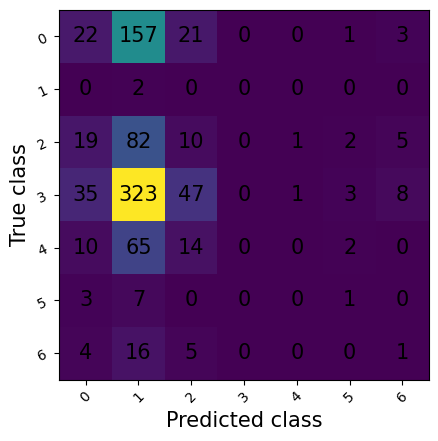

In [14]:
trainer.test(model=xlm_roberta, dataloaders=[vf_dl])

# Additional Testing

In [15]:
from pathlib import Path

xlm_roberta = NLPModel.load_from_checkpoint(Path("fakenews-detection") / "model.ckpt")

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
roberta_model = xlm_roberta.model.roberta

In [17]:
import torch
import pandas as pd

In [18]:
class VerafilesDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        super().__init__()
        
        self.root = root
        self.transform = transform
        self.df = pd.read_csv(root)

        self.idx2label = {k:v for k,v in enumerate(self.df["label"].unique())}
        self.label2idx = {v:k for k,v in self.idx2label.items()}

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        text = row["text"]
        label = self.label2idx[row["label"]]
        return {
            "text": text,
            "label": label
        }

In [19]:
class XFactDataset(torch.utils.data.Dataset):
    def __init__(self, root, examples=20, transform=None):
        super().__init__()
        
        self.root = root
        self.transform = transform
        self.df = pd.read_csv(root, sep="\t")

        self.idx2label = {k:v for k,v in enumerate(self.df["label"].unique())}
        self.label2idx = {v:k for k,v in self.idx2label.items()}

        self.df = pd.concat([self.df[self.df["label"] == key].head(examples) for key in self.label2idx.keys()], ignore_index=True)

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        text = row["claim"]
        label = self.label2idx[row["label"]]
        return {
            "text": text,
            "label": label
        }

In [20]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base", )

In [21]:
tokenizer

XLMRobertaTokenizerFast(name_or_path='xlm-roberta-base', vocab_size=250002, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)}, clean_up_tokenization_spaces=True)

In [22]:
def collate_fn(batch):

    tokenized = tokenizer([x["text"] for x in batch], padding=True)

    return {
        "input_ids": torch.tensor(tokenized["input_ids"]),
        "attention_mask": torch.tensor(tokenized["attention_mask"]),
        "labels": torch.tensor([x["label"] for x in batch]),
    }

In [23]:
vf_ds = VerafilesDataset("vefafiles.csv", transform=None)
vf_dl = torch.utils.data.DataLoader(vf_ds, collate_fn=collate_fn, batch_size=8)

In [24]:
xf_ds = XFactDataset("xlm_fakenews/train.tsv")
xf_dl = torch.utils.data.DataLoader(xf_ds, collate_fn=collate_fn, batch_size=8)

In [25]:
from torch.utils.tensorboard import SummaryWriter
import numpy as np

In [26]:
writer = SummaryWriter()

In [27]:
roberta_model = roberta_model.to("mps")

In [28]:
embeddings = []
labels = []

for batch in vf_dl:

    input_ids = batch["input_ids"].to("mps")
    attention_mask = batch["attention_mask"].to("mps")
    labels_batch = batch["labels"]
    
    labels_batch = ["vf"+vf_ds.idx2label[x.item()] for x in labels_batch] # convert to normal index
    labels.extend(labels_batch)

    # print(type(input_ids))

    with torch.no_grad():
        outputs = roberta_model(input_ids=input_ids, attention_mask=attention_mask)
        embeddings.append(outputs.last_hidden_state[:, 0, :].cpu().numpy())

In [29]:
for batch in xf_dl:

    input_ids = batch["input_ids"].to("mps")
    attention_mask = batch["attention_mask"].to("mps")
    labels_batch = batch["labels"]
    
    labels_batch = ["xf"+xf_ds.idx2label[x.item()] for x in labels_batch] # convert to normal index
    labels.extend(labels_batch)

    # print(type(input_ids))

    with torch.no_grad():
        outputs = roberta_model(input_ids=input_ids, attention_mask=attention_mask)
        embeddings.append(outputs.last_hidden_state[:, 0, :].cpu().numpy())

In [30]:
embeddings_cat = np.concatenate(embeddings)

In [31]:
embeddings_cat.shape

(1010, 768)

In [32]:
writer.add_embedding(embeddings_cat, metadata=labels, tag="vf_and_xf_representation")
writer.close()

In [33]:
xf_ds.idx2label

{0: 'false',
 1: 'partly true/misleading',
 2: 'true',
 3: 'mostly true',
 4: 'mostly false',
 5: 'complicated/hard to categorise',
 6: 'other'}